In [1]:
using DataFrames
using CSV
using Glob
using Chain
using Statistics
using SimSpread
using ArgParse
using Base.Threads
using MLBase
using ProgressMeter
using AlgebraOfGraphics
using CairoMakie
using Plots
using StatsPlots
# include("getmetrics.jl")
using MLJ
using ProgressMeter
# using Base.Threads

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA ~/.julia/packages/CUDA/s0e3j/src/initialization.jl:70


In [3]:
function gobl(path::String)
    files = glob("*.out", path)
    df = DataFrame()
    
    for file in files
    # extract
    α = @chain file begin
        basename
        replace(".out" => "")
        split('.')
        last
        split('_')
        last
        end
    
    α_value = if startswith(α, "00")
              parse(Float64, α, ) / 100
          else
              parse(Float64, α) / 10
          end
 
    
    # file to df
    file_df = CSV.File(file, delim=",", header=["Fold", "Ligando", "Target", "Score", "TP"]) |> DataFrame
    
    # add alpha 
    file_df[!, "Alpha"] .= α_value
    
    append!(df, file_df)
    end
    
    return df
end

# open and format csv file data to compatible dataframe
function open_csv(path::String)
    files = glob("*.no_header.csv", path)
    df = DataFrame()
    
    for file in files
        file_df = CSV.read(file, DataFrame, header=["Ligando", "Target", "TP", "Score", "Alpha"]) 
        append!(df, file_df)
    end
    
    
    return df
end
    
# format dataframes to match standard format.
function rescore(df::DataFrame)
    df = @chain df begin
        select([:Ligando, :Target, :Score, :TP, :Alpha])
        groupby([:Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
    end
    return df
end

# outputs all the scores of the dataframe into columns and calculates different estimators for each element of a vector of functions
function rescore(df::DataFrame, fxs::Vector{Function}, benchmark::String="0.2")
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    df_2 = @chain df begin
        groupby([:Ligando, :Target, :TP, :Alpha])    
        combine(:Score => sum => :Score)
        unstack(:Alpha, :Score)
        DataFrames.transform(AsTable(5:tcols) .=> ByRow.(fxs) .=> symbs)
        select(1:3, [benchmark], symbs)
    end
    return df_2
end

# trains ml model on the scores columns.
function train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model="0", benchmark::String="0.2"; args...)
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    fxm_name = String(Symbol(model))
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    


    
    if model != "0"
    #     scitypes and prepare data, rng is random seed to randomize rows on the split.
        y, X =  machine_input(df_train; rng=123)

        # train machine and get parameters
        Model = model
        model = Model()
        m1 = machine(model(;args...), X, y) |> fit!
        params = fitted_params(m1)

    #     prepare test set for machine predictions
        y, X =  machine_input(df)
        
    #     predict
        yhat = MLJ.predict_mode(m1, X)
        df = rescore(df)
        df = @chain df begin
            DataFrames.transform(AsTable(4:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:3, [benchmark], symbs)
        end
#         add predictions to df
        df[!, fxm_name] = yhat
    else
        df = rescore(df)
        df = @chain df begin
            DataFrames.transform(AsTable(4:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:3, [benchmark], symbs)
        end
    end
    if model == "0"
        params = 0
    end
    return df, params
end


# with dimensionality reduction
function train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model="0", benchmark::String="0.2", fxd=nothing; args...)
    symbs = []
    
    uniq = df[:, :Alpha]
    tcols = size(unique(uniq))[1] + ncol(df) - 3
    
    fxm_name = String(Symbol(model))
    
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    
    
    if model != "0"
    #     scitypes and prepare data for training, rng is random seed to randomize rows on the split.
        y, X =  machine_input(df_train; rng=123)
        
        if fxd !== nothing

            #dimensionality reduction of features 
            
            dModel = fxd
            dmodel = dModel()
            dm = machine(dmodel(maxoutdim=5), X) |> fit!
            Xp = MLJ.transform(dm, X)
            X = Xp
        end

        # train machine and get parameters
        Model = model
        model = Model()
        m1 = machine(model(;args...), X, y) |> fit!
        params = fitted_params(m1)

    #     MLJ based transformation of test dataframe to make predictions
        y, X =  machine_input(df)
        
        if fxd !== nothing
            Xp = MLJ.transform(dm, X)
            X = Xp
        end
        
    #     predict
        yhat = MLJ.predict_mode(m1, X)
        df = rescore(df)
        df = @chain df begin
            DataFrames.transform(AsTable(4:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:3, [benchmark], symbs)
        end
        df[!, fxm_name] = yhat
    else
        df = rescore(df)
        df = @chain df begin
            DataFrames.transform(AsTable(4:tcols) .=> ByRow.(fxs) .=> symbs)
            select(1:3, [benchmark], symbs)
        end
    end
    if model == "0"
        params = 0
    end
    return df, params
end

function machine_input(df; args...)
y, X = prepare_machine(rescore(df); args...)
end


function prepare_machine(df::DataFrame; args...)

    #     this is for scitype compatibility with machine
    df = select(df, 3:ncol(df))
    df[!, 2:end] = convert.(Float64, df[!, 2:end])
    df = coerce(df, :TP=>Multiclass)
    y, X = unpack(df, ==(:TP); args...)
    return y, X
end

function log_reg()
#     instantiate model
    return @iload LogisticClassifier pkg=MLJLinearModels verbosity=0
end

function rf_class()
#     instantiate model
     return @iload RandomForestClassifier pkg=DecisionTree verbosity=0
#     https://alan-turing-institute.github.io/MLJ.jl/dev/models/RandomForestClassifier_DecisionTree/#RandomForestClassifier_DecisionTree
end

function xgb_class()
#     instantiate model
     return @iload XGBoostClassifier pkg=XGBoost verbosity=0
end

function pca_dimred()
    return @iload PCA pkg=MultivariateStats verbosity=0
end

function sklearn_rf_class()
    return @iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
#     https://alan-turing-institute.github.io/MLJ.jl/dev/models/RandomForestClassifier_MLJScikitLearnInterface/#RandomForestClassifier_MLJScikitLearnInterface
#     https://statistics.berkeley.edu/tech-reports/666
end

function evaluate(df::DataFrame, fxs::Vector{Function}, yhat="0", benchmark::String="0.2")
    df_f = DataFrame()
    
    symbs = []
    for f in fxs
        push!(symbs, String(Symbol(f)))
    end
    push!(symbs, benchmark)
    
#     if using ml model, and model function is provided, add function name 
    if yhat != "0"
        push!(symbs, String(Symbol(yhat)))
    else
        
    end
    
    for metric in symbs
        df_t = @chain df begin
            select(["Ligando", "Target", "TP" , metric])
            rename!(4 => :Score)
        end
        
        df_m = getperformance(df_t)
        df_m.groupid = replace(df_m.groupid, missing => metric)
        append!(df_f, df_m)
    end
    
    return df_f
end


function plotmetrics(df::DataFrame, benchmark::String="0.2")
    gr()
        
    df_plot = @chain df begin
        stack(names(df[:, 2:end]), :groupid)
        unstack(:groupid, :value)
        rename!(:variable => :metric)
    end
    
    df_perct = copy(df_plot)
    for n in 2:ncol(df_perct)
    df_perct[:, n] .= (df_plot[:, n] .- df_plot[:,benchmark]) ./ df_plot[:,benchmark]
    end
    
    plot1 = @df df_plot groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    plot2 = @df df_perct groupedbar(
    :metric,
    cols(2:ncol(df_plot)),
    bar_width=0.7,
    framestyle = :box,
    lw = 0,
    guidefontsize = 8,
    )
    
    return plot1, plot2, df_plot, df_perct
end;

# getmetrics.jl functions

function getperformance(
    df::DataFrame;
    ycol::String="TP",
    yhatcol::String="Score",
#   estoy agregando columna ligandos para funcion r@ y p@
    ligcol::String="Ligando"
)
    # Initialize function
    score = convert(Vector{Float64}, df[!, yhatcol])
    tp = convert(Vector{Bool}, df[!, ycol])
#   grouping para la nueva funcion
    grouping = df[!, ligcol]

    # Generate confusion matrix and common metrics
    thresholds = sort(unique(score))

    confusion =MLBase.roc(tp, score, thresholds)
    recalls = SimSpread.recall.(confusion)
    precisions = SimSpread.precision.(confusion)
    tprs =MLBase.true_negative_rate.(confusion)
    fprs =MLBase.false_negative_rate.(confusion)

    # Standard metrics
    auprc = SimSpread.AuPRC(tp, score)
    auroc = SimSpread.AuROC(tp, score)

    # Early recognition
    bedroc = SimSpread.BEDROC(tp, score)
#     agregando implementacion de r@20 y p@20 de update de SimSpread 03/04/2023
    r20 = SimSpread.recallatL(tp, score, grouping, 20)
    p20 = SimSpread.precisionatL(tp, score, grouping, 20)

    # Binary metrics
    f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
    bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
    acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
    mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

    return DataFrame(
        groupid=[missing],
        AuROC=[auroc],
        AuPRC=[auprc],
        BEDROC=[bedroc],
        r20 = [r20],
        p20 = [p20],
        f1=[f1],
        bacc=[bacc],
        acc=[acc],
        mcc = [mcc],
    )
end

function getperformance(
    df::DataFrame,
    groupby::String;
    ycol::String="TP",
    yhatcol::String="Score"
)
    # Initialize function
    grouper = df[!, groupby]
    alltp = convert(Vector{Bool}, df[!, ycol])
    allscore = convert(Vector{Float64}, df[!, yhatcol])

    # Evaluate performance per group
    groupperformance = DataFrame()
    for groupᵢ in unique(grouper)
        # Get group scores and true-positive state
        tp = alltp[grouper.==groupᵢ]
        score = allscore[grouper.==groupᵢ]

        # Confusion matrix
        thresholds = sort(unique(score))

        confusion =MLBase.roc(tp, score, thresholds)
        recalls = SimSpread.recall.(confusion)
        precisions = SimSpread.precision.(confusion)
        tprs =MLBase.true_negative_rate.(confusion)
        fprs =MLBase.false_negative_rate.(confusion)

        # Standard metrics
        auprc = SimSpread.AuPRC(tp, score)
        auroc = SimSpread.AuROC(tp, score)

        # Early recognition
        bedroc = SimSpread.BEDROC(tp, score)
        # r20 = SimSpread.performanceatL(tp, score, SimSpread.recall)
        # p20 = SimSpread.performanceatL(tp, score, SimSpread.precision)

        # Binary metrics
        f1 = SimSpread.maxperformance(confusion, SimSpread.f1score)
        bacc = SimSpread.maxperformance(confusion, SimSpread.balancedaccuracy)
        acc = SimSpread.maxperformance(confusion, SimSpread.accuracy)
        # mcc = SimSpread.maxperformance(confusion, SimSpread.mcc)

        append!(
            groupperformance,
            DataFrame(
                groupid=[groupᵢ],
                AuROC=[auroc],
                AuPRC=[auprc],
                BEDROC=[bedroc],
                # r20 = [r20],
                # p20 = [p20],
                f1=[f1],
                bacc=[bacc],
                acc=[acc],
                # mcc = [mcc],
            )
        )
    end

    return groupperformance
end

getperformance (generic function with 2 methods)

In [4]:
function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm="0", benchmark::String="0.2"; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark:: NBI algorithm alpha value to benchmark performance.
    
    """
    df1, params = train_rescore(df, df_train, fxs, fxm, benchmark; args...)
    df2 = evaluate(df1, fxs, fxm, benchmark)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return params, df_plot, df_perct
end
    

function allmetrics(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, fxm="0", benchmark::String="0.2", dfx =nothing; args...)
    """
    df: test dataframe
    df_train: training dataframe
    fxs: vector of functions to apply
    fxm: model function to provide Data_Type() of MLJ model. Default to "0" doesn't apply model fit and predictions 
    benchmark: NBI algorithm alpha value to benchmark performance.
    dfx: dimensionality reduction model.
    
    """
    df1, params = train_rescore(df, df_train, fxs, fxm, benchmark, dfx; args...)
    df2 = evaluate(df1, fxs, fxm, benchmark)
    plot1, plot2, df_plot, df_perct = plotmetrics(df2, benchmark)
    display(plot1)
    display(plot2)
    return params, df_plot, df_perct
end
    

allmetrics (generic function with 4 methods)

In [5]:
path = "/CLUSTERFS/homes/fnmelo/Bioinf_2"
path_train = "/CLUSTERFS/homes/fnmelo/test_predictions"
df = gobl(path)
df_train = open_csv(path_train)

Row,Ligando,Target,TP,Score,Alpha
,String15,String15,Float64,Float64,Float64
1,CHEMBL1000,CHEMBL1075102,0.0,0.000888101,0.0
2,CHEMBL1000,CHEMBL1075104,0.0,0.000771602,0.0
3,CHEMBL1000,CHEMBL1075132,0.0,0.00268097,0.0
4,CHEMBL1000,CHEMBL1075144,0.0,0.000894454,0.0
5,CHEMBL1000,CHEMBL1075145,0.0,0.000893652,0.0
6,CHEMBL1000,CHEMBL1075162,0.0,0.0017873,0.0
7,CHEMBL1000,CHEMBL1075165,0.0,0.00266984,0.0
8,CHEMBL1000,CHEMBL1075322,0.0,0.000893652,0.0
9,CHEMBL1000,CHEMBL1075323,0.0,0.000892863,0.0


In [14]:
df

Row,Fold,Ligando,Target,Score,TP,Alpha
,Int64,String15,String15,Float64,Float64,Float64
1,1,CHEMBL1062,CHEMBL1075132,2.27353e-5,0.0,0.0
2,1,CHEMBL1062,CHEMBL1075145,5.10256e-6,0.0,0.0
3,1,CHEMBL1062,CHEMBL1075165,2.16946e-5,0.0,0.0
4,1,CHEMBL1062,CHEMBL1075323,9.05151e-6,0.0,0.0
5,1,CHEMBL1062,CHEMBL1163125,4.21232e-5,0.0,0.0
6,1,CHEMBL1062,CHEMBL1250378,6.50849e-6,0.0,0.0
7,1,CHEMBL1062,CHEMBL1293224,1.6584e-5,0.0,0.0
8,1,CHEMBL1062,CHEMBL1293226,2.15297e-5,0.0,0.0
9,1,CHEMBL1062,CHEMBL1293267,2.88745e-5,0.0,0.0


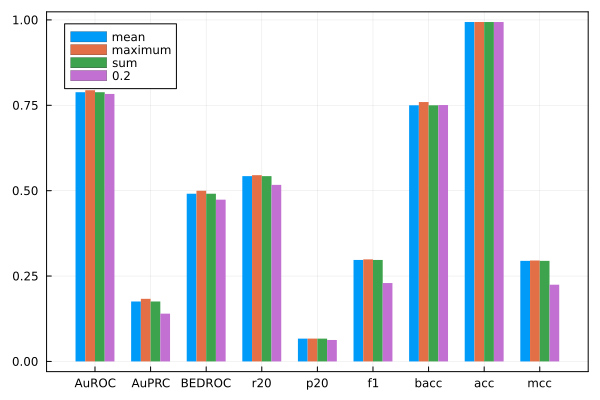

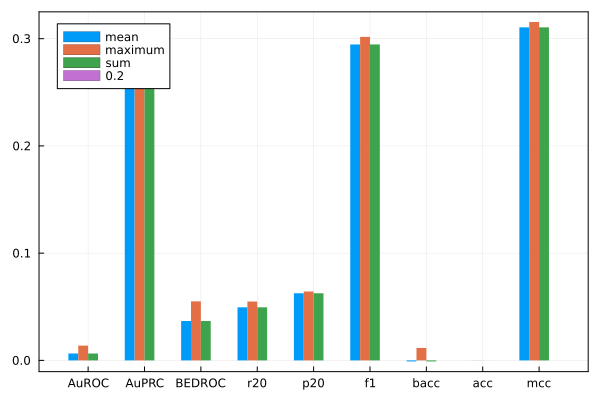

(0, 9×5 DataFrame
 Row │ metric  mean       maximum    sum        0.2       
     │ String  Float64?   Float64?   Float64?   Float64?  
─────┼────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685
   4 │ r20     0.542592   0.545372   0.542592   0.517002
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364
   6 │ f1      0.297174   0.298799   0.297174   0.229549
   7 │ bacc    0.750061   0.759519   0.750061   0.750781
   8 │ acc     0.993862   0.993946   0.993862   0.993846
   9 │ mcc     0.294465   0.295586   0.294465   0.224686, 9×5 DataFrame
 Row │ metric  mean          maximum      sum           0.2      
     │ String  Float64?      Float64?     Float64?      Float64? 
─────┼───────────────────────────────────────────────────────────
   1 │ AuROC    0.00643421   0.0137839     0.00643421        0.0
   2 │ AuPRC  

In [15]:
# testing without model
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs)

In [16]:
# search for models compatible with model name, is native julia and based on keyword

y, X = machine_input(df)
compatible_models = models(matching(X, y))

filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "logistic"),
    compatible_models
)

1-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = LogisticClassifier, package_name = MLJLinearModels, ... )

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


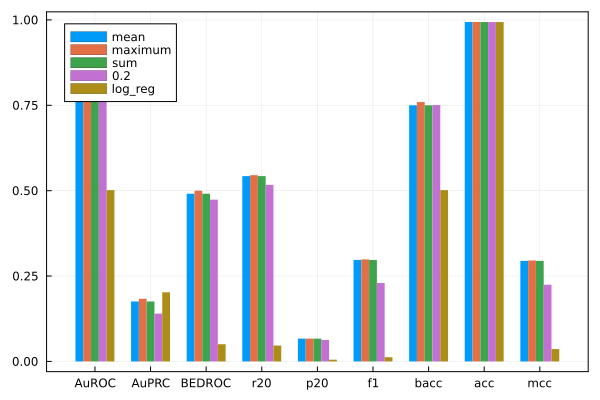

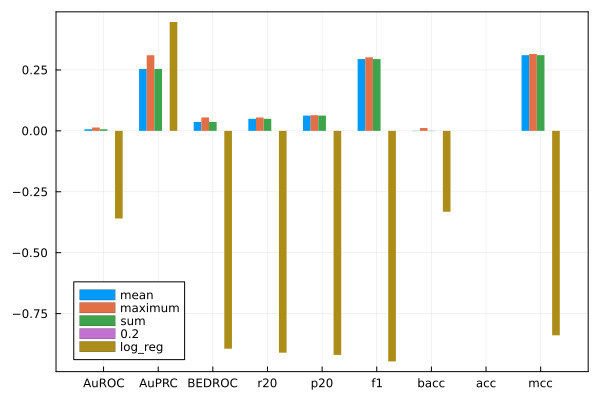

((classes = CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 1.0], coefs = [Symbol("0.0") => -46.52741708206149, Symbol("0.05") => -41.370334699537615, Symbol("0.1") => -11.854329457912646, Symbol("0.15") => 4.537169266599146, Symbol("0.2") => 4.001737290458733, Symbol("0.25") => -5.955737918904419, Symbol("0.3") => -7.167471733932347, Symbol("0.35") => 10.65491999297085, Symbol("0.4") => -4.870853449313455, Symbol("0.45") => -4.700108342199293  …  Symbol("0.55") => 3.4906041455877954, Symbol("0.6") => 10.908042126129729, Symbol("0.65") => -12.866086125825456, Symbol("0.7") => -8.745301182401334, Symbol("0.75") => 6.838080913464334, Symbol("0.8") => 1.0268469726459328, Symbol("0.85") => -1.4609373280795586, Symbol("0.9") => 2.4369109141724414, Symbol("0.95") => 11.559833653193895, Symbol("1.0") => 20.821132538197457], intercept = -8.12879730892683), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        log_reg    
     │ String  Float64?   Float64?   Float64?

In [17]:
@load LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, log_reg, "0.2", penalty = :none)

In [18]:
# search for models compatible with datatypes, is native julia and based on keyword
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "Forest"),
    compatible_models
)

2-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


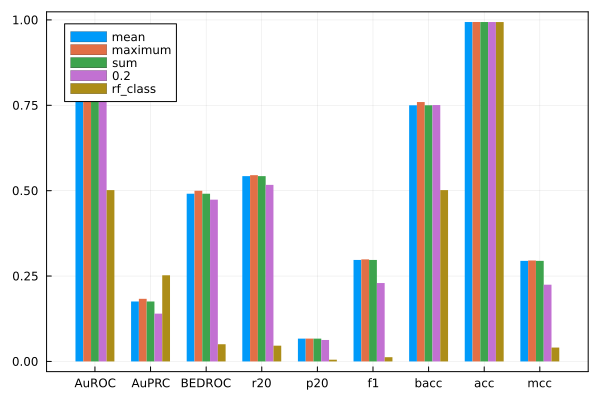

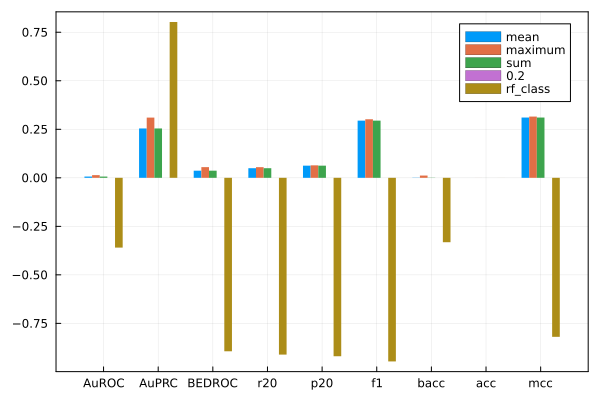

((forest = Ensemble of Decision Trees
Trees:      1000
Avg Leaves: 368.506
Avg Depth:  23.221,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum

In [19]:
# Rnadom Forest Classifier model
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2"; n_trees=1000)

[ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).


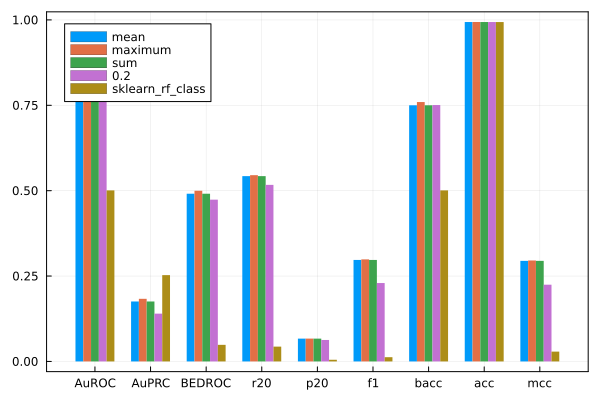

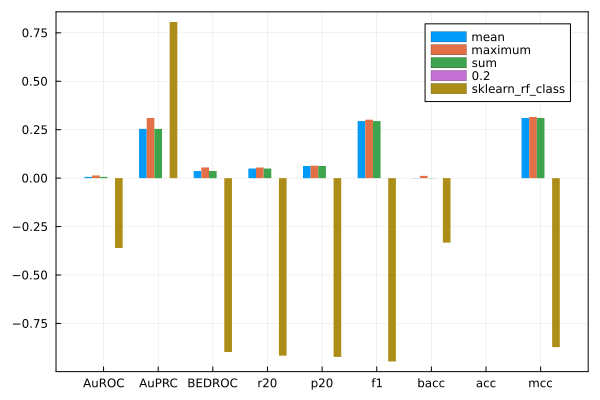

((estimator = <py DecisionTreeClassifier()>, estimators = <py [DecisionTreeClassifier(max_features='sqrt', random_state=1894063361), DecisionTreeClassifier(max_features='sqrt', random_state=1514887556), DecisionTreeClassifier(max_features='sqrt', random_state=314779422), DecisionTreeClassifier(max_features='sqrt', random_state=1616998969), DecisionTreeClassifier(max_features='sqrt', random_state=628393207), DecisionTreeClassifier(max_features='sqrt', random_state=1860925168), DecisionTreeClassifier(max_features='sqrt', random_state=122510081), DecisionTreeClassifier(max_features='sqrt', random_state=1044084942), DecisionTreeClassifier(max_features='sqrt', random_state=131571076), DecisionTreeClassifier(max_features='sqrt', random_state=1615278067), DecisionTreeClassifier(max_features='sqrt', random_state=2102392203), DecisionTreeClassifier(max_features='sqrt', random_state=605398524), DecisionTreeClassifier(max_features='sqrt', random_state=455150875), DecisionTreeClassifier(max_featur

In [20]:
# Rnadom Forest Classifier model; sklearn version; imbalanced Hyper-parameter balancing subsamples
@iload RandomForestClassifier pkg=MLJScikitLearnInterface verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, sklearn_rf_class, "0.2", class_weight = "balanced_subsample")

In [21]:
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
rft_df, param = train_rescore(df, df_train, fxs, rf_class)
rft_df[1:10, 3:end]


[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


Row,TP,0.2,mean,maximum,sum,rf_class
,Float64,Float64?,Float64?,Float64?,Float64?,Cat…
1,0.0,0.0,4.71153e-6,5.02698e-5,9.89422e-5,0.0
2,0.0,0.0,5.89425e-7,5.72355e-6,1.23779e-5,0.0
3,0.0,0.0,2.49448e-6,2.20103e-5,5.23842e-5,0.0
4,0.0,0.0,1.24007e-6,9.3893e-6,2.60415e-5,0.0
5,0.0,0.0,5.41803e-6,4.35057e-5,0.000113779,0.0
6,0.0,0.0,3.27955e-6,5.37322e-5,6.88706e-5,0.0
7,0.0,0.0,2.21683e-6,1.6584e-5,4.65534e-5,0.0
8,0.0,0.0,6.18155e-6,5.93017e-5,0.000129813,0.0
9,0.0,0.0,3.9174e-6,3.11141e-5,8.22653e-5,0.0


In [22]:
df2 = evaluate(rft_df, fxs, rf_class)


Row,groupid,AuROC,AuPRC,BEDROC,r20,p20,f1,bacc,acc,mcc
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,mean,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
2,maximum,0.794083,0.183345,0.49976,0.545372,0.0668737,0.298799,0.759519,0.993946,0.295586
3,sum,0.788326,0.175512,0.491081,0.542592,0.0667702,0.297174,0.750061,0.993862,0.294465
4,0.2,0.783286,0.13993,0.473685,0.517002,0.0628364,0.229549,0.750781,0.993846,0.224686
5,rf_class,0.50167,0.252268,0.0503431,0.0461262,0.00507246,0.0123974,0.50167,0.993763,0.0406123


In [23]:
plot1, plot2, df_plot, df_perct = plotmetrics(df2)

(Plot{Plots.GRBackend() n=5}, Plot{Plots.GRBackend() n=5}, 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum           0.2       rf_class    
    

[ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).


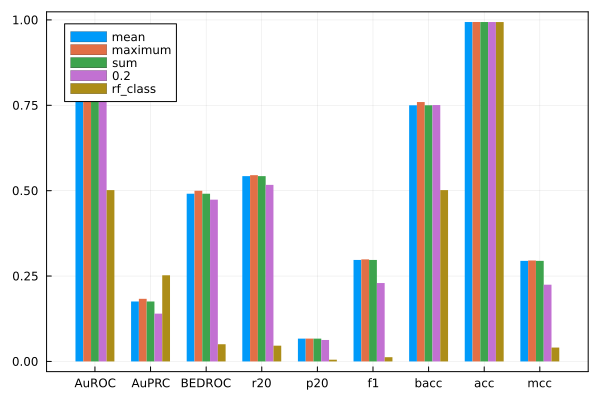

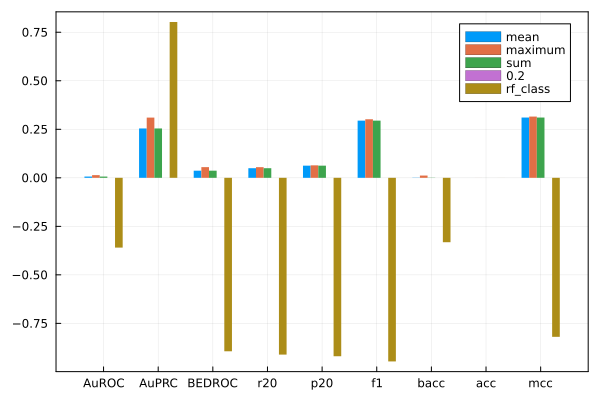

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 162.77
Avg Depth:  10.0,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class   
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum    

In [24]:
# Rnadom Forest Classifier model; max tree depth = 10
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2", max_depth = 10)

In [25]:
filter(
#     check for pure julia models
    m -> m.is_pure_julia && 
             contains(m.docstring * m.name, "XGBoost"),
    compatible_models
)

NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}[]

[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43811215912336926
[ Info: [2]	train-logloss:0.29723195074581049
[ Info: [3]	train-logloss:0.20846369806223358
[ Info: [4]	train-logloss:0.14906013994798784
[ Info: [5]	train-logloss:0.10795153038957117
[ Info: [6]	train-logloss:0.07889302434027963
[ Info: [7]	train-logloss:0.05806155779355582
[ Info: [8]	train-logloss:0.04300037888797514
[ Info: [9]	train-logloss:0.03202238397757251
[ Info: [10]	train-logloss:0.02398841784658621
[ Info: [11]	train-logloss:0.01808547770140565
[ Info: [12]	train-logloss:0.01374522392956640
[ Info: [13]	train-logloss:0.01053736201481398
[ Info: [14]	train-logloss:0.00817485653593866
[ Info: [15]	train-logloss:0.00641676919023152
[ Info: [16]	train-logloss:0.00511371046687504
[ Info: [17]	train-logloss:0.00414515752712833
[ Info: [18]	train-logloss:0.00342248422887057
[ Info: [19]	train-logloss:0.00288827537363638
[ Info: [20]	train-

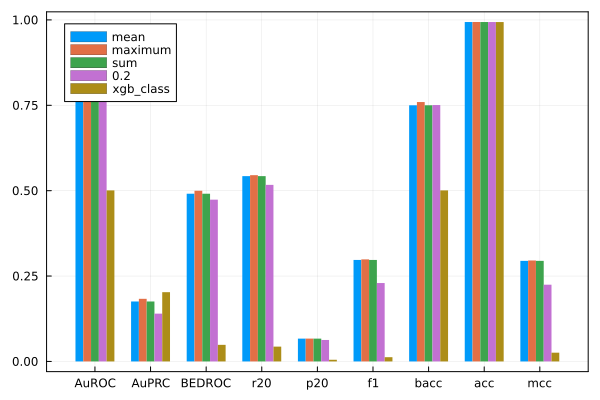

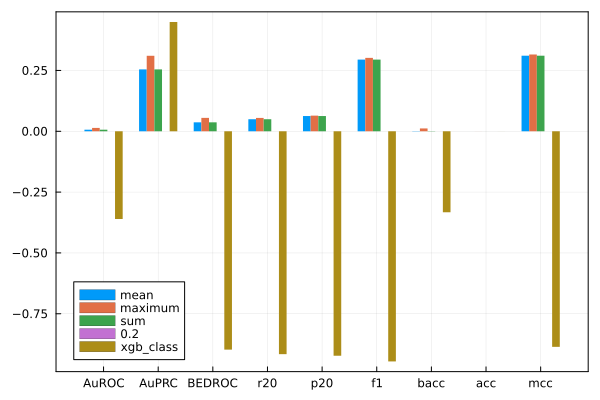

((fitresult = (XGBoost.Booster(), CategoricalArrays.CategoricalValue{Float64, UInt32} 0.0),), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        xgb_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.500832
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.202777
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0485714
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0433657
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00486542
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.500832
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993757
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0256042, 9×6 DataFrame
 Row │ metric  mean          maximum      sum 

In [26]:
@iload XGBoostClassifier pkg=XGBoost verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, xgb_class, "0.2")

In [27]:
PCA = @iload PCA pkg=MultivariateStats verbosity=0

y, X = machine_input(df_train)

model = PCA(maxoutdim=5)
mach = machine(model, X) |> fit!

Xproj = MLJ.transform(mach, X)



[ Info: Training machine(PCA(maxoutdim = 5, …), …).


Row,x1,x2,x3
,Float64,Float64,Float64
1,0.0233243,-0.00590629,0.00429616
2,0.0233304,-0.00598846,0.00442771
3,0.0228247,-0.00248194,0.00116615
4,0.0233497,-0.00608173,0.0044434
5,0.0231909,-0.00495382,0.00345103
6,0.0174896,0.0200269,-0.00438554
7,0.0229344,-0.00288277,0.00117868
8,0.0223826,-0.00128176,0.00216392
9,0.0230027,-0.00415885,0.00327383


In [28]:
y, X = prepare_machine(rescore(df))
Xproj = MLJ.transform(mach, X)

Row,x1,x2,x3
,Float64,Float64,Float64
1,0.023397,-0.0066259,0.00524119
2,0.0233986,-0.0066435,0.00526584
3,0.0233981,-0.00663678,0.00525556
4,0.0233983,-0.00664069,0.00526204
5,0.0233971,-0.00662553,0.00523914
6,0.0233974,-0.00663053,0.00524843
7,0.0233981,-0.00663725,0.00525664
8,0.0233935,-0.00660515,0.00522859
9,0.0233976,-0.00663107,0.0052473


In [29]:
# Add dimensionality reduction and the the ensemble model

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


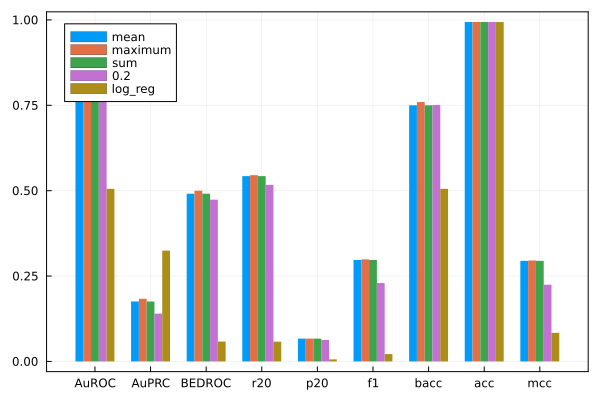

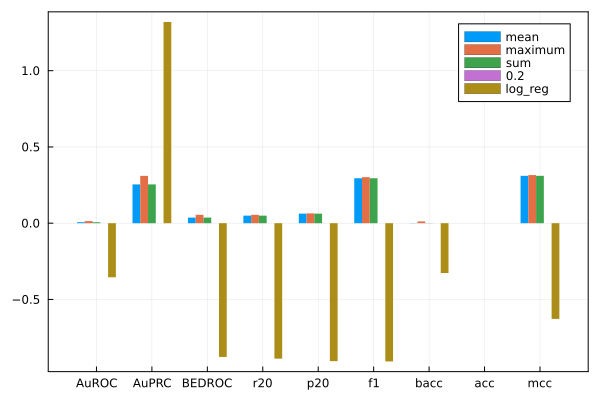

((classes = CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 1.0], coefs = [:x1 => -6.29559377136553, :x2 => -10.956993537091572, :x3 => -0.9121851483974341], intercept = -8.312063120170532), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        log_reg    
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.505444
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.324534
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0582949
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0578585
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00600414
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0214876
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.505444
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993794
   9 │ mcc     0.294465 

In [30]:
@iload PCA pkg=MultivariateStats verbosity=0
@load LogisticClassifier pkg=MLJLinearModels verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, log_reg, "0.2", pca_dimred)
# train_rescore(df::DataFrame, df_train::DataFrame, fxs::Vector{Function}, model="0", benchmark::String="0.2", fxd=nothing; args...)

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


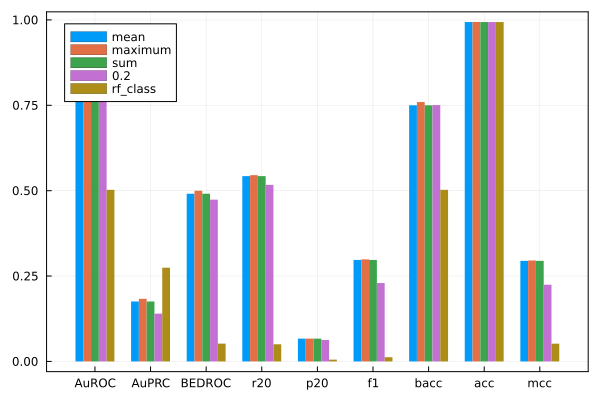

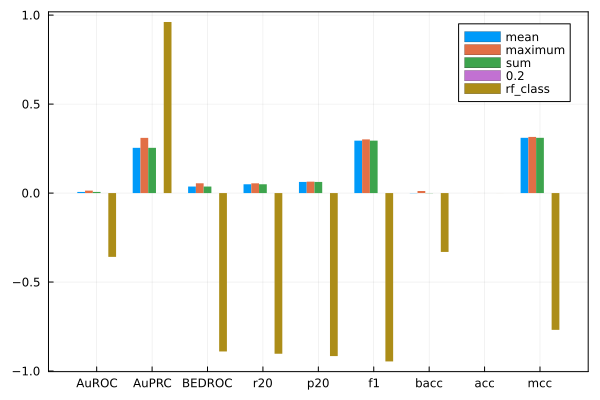

((forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 459.04
Avg Depth:  25.46,), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        rf_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?  
─────┼───────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.502508
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.274455
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0521145
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.050267
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.0052795
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.502508
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993768
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0520065, 9×6 DataFrame
 Row │ metric  mean          maximum      sum      

In [6]:
@iload PCA pkg=MultivariateStats verbosity=0
@iload RandomForestClassifier pkg=DecisionTree verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, rf_class, "0.2", pca_dimred)

[ Info: Training machine(PCA(maxoutdim = 5, …), …).
[ Info: Training machine(XGBoostClassifier(test = 1, …), …).
[ Info: XGBoost: starting training.
[ Info: [1]	train-logloss:0.43815276938077885
[ Info: [2]	train-logloss:0.29730765679298776
[ Info: [3]	train-logloss:0.20856610679820262
[ Info: [4]	train-logloss:0.14920440934615278
[ Info: [5]	train-logloss:0.10812974569846873
[ Info: [6]	train-logloss:0.07908879918159666
[ Info: [7]	train-logloss:0.05828357697463905
[ Info: [8]	train-logloss:0.04323228340778950
[ Info: [9]	train-logloss:0.03227298390895190
[ Info: [10]	train-logloss:0.02425300680745448
[ Info: [11]	train-logloss:0.01836436013300912
[ Info: [12]	train-logloss:0.01402863058594921
[ Info: [13]	train-logloss:0.01083383758325947
[ Info: [14]	train-logloss:0.00847386310717808
[ Info: [15]	train-logloss:0.00673280020348132
[ Info: [16]	train-logloss:0.00544188879630708
[ Info: [17]	train-logloss:0.00448036871003094
[ Info: [18]	train-logloss:0.00376999020235333
[ Info: [19]	t

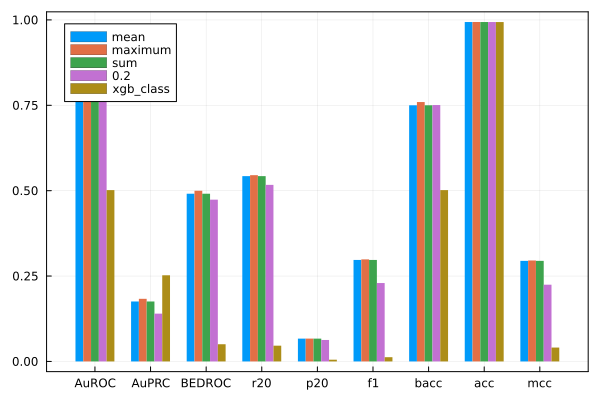

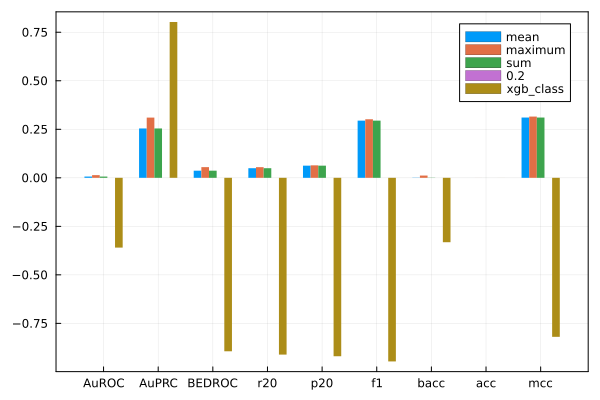

((fitresult = (XGBoost.Booster(), CategoricalArrays.CategoricalValue{Float64, UInt32} 0.0),), 9×6 DataFrame
 Row │ metric  mean       maximum    sum        0.2        xgb_class  
     │ String  Float64?   Float64?   Float64?   Float64?   Float64?   
─────┼────────────────────────────────────────────────────────────────
   1 │ AuROC   0.788326   0.794083   0.788326   0.783286   0.50167
   2 │ AuPRC   0.175512   0.183345   0.175512   0.13993    0.252268
   3 │ BEDROC  0.491081   0.49976    0.491081   0.473685   0.0503431
   4 │ r20     0.542592   0.545372   0.542592   0.517002   0.0461262
   5 │ p20     0.0667702  0.0668737  0.0667702  0.0628364  0.00507246
   6 │ f1      0.297174   0.298799   0.297174   0.229549   0.0123974
   7 │ bacc    0.750061   0.759519   0.750061   0.750781   0.50167
   8 │ acc     0.993862   0.993946   0.993862   0.993846   0.993763
   9 │ mcc     0.294465   0.295586   0.294465   0.224686   0.0406123, 9×6 DataFrame
 Row │ metric  mean          maximum      sum   

In [7]:
@iload PCA pkg=MultivariateStats verbosity=0
@iload XGBoostClassifier pkg=XGBoost verbosity=0
fxs = [mean, maximum, sum]
allmetrics(df, df_train, fxs, xgb_class, "0.2", pca_dimred)